In [1]:
## Imports

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
import random as r
from math import *
from numpy import linalg as LA
import os
import osmnx as ox

In [2]:
## Exemples


Petersen = nx.petersen_graph()
C6 = nx.cycle_graph(6)
Biparti34 = nx.complete_bipartite_graph(3,4)

pos_bip34 = {0 : [-1,1], 1 : [0,1], 2 : [1, 1], 3 : [-1.5, -1], 4 : [-0.5, -1], 5 : [0.5, -1], 6 : [1.5, -1]}



def downloadVille(location,nom_fichier):
    base_filepath = "C:/Users/Dreyer Simon/Documents/Travail/5A/Stage de recherche/code_python/data/"
    G = ox.graph_from_place(location, network_type="drive")
    G = rename_nodes(G)

    filepath = base_filepath + nom_fichier + ".graphml"
    ox.save_graphml(G, filepath)


def loadVille(nom_fichier):
    base_filepath = "C:/Users/Dreyer Simon/Documents/Travail/5A/Stage de recherche/code_python/data/"
    filepath = base_filepath + nom_fichier + ".graphml"

    return ox.load_graphml(filepath)



Piedmont = loadVille("piedmont")

In [5]:
print(Piedmont)

MultiDiGraph with 352 nodes and 944 edges


# 1. Complexité algo

## 1.0. Fonctions utiles

In [3]:
## Utils



def c_recherche_dicho(table,rang):
    """Renvoie l'indice i tel que table[i-1] <= rang < table[i]"""
    compteur = 0
    if (rang < table[0]):
        return (0,compteur)

    a = 0
    b = len(table)-1

    while(b-a > 1):
        #On garde l'invariant table[a] <= rang < table[b]
        compteur +=1
        m = (a + b)//2
        if table[m]<=rang:
            a = m
        else:
            b = m
    return (b,compteur)


def c_recherche_dicho_par_coordonnee(table,rang,coordonnee):
    """Renvoie l'indice i tel que table[i-1][coordonnee] <= rang < table[i][coordonnee]"""
    compteur = 0
    if (rang < table[0][coordonnee]):
        return (0,compteur)

    a = 0
    b = len(table)-1

    while(b-a > 1):
        #On garde l'invariant table[a][coordonnee] <= rang < table[b][coordonnee]
        compteur +=1
        m = (a + b)//2
        if table[m][coordonnee]<=rang:
            a = m
        else:
            b = m
    return (b,compteur)




def c_inverse_dist(dist):
    """Prend le dictionnaire des distance et renvoie un dictionnaire où inv[d] = [liste des à distance d]"""
    inverse = {}
    compteur = 0

    for noeud,distance in dist.items():
        inverse.setdefault(distance, []).append(noeud)
        compteur += 1
    return (inverse,compteur)


def rename_nodes(G):
    return nx.convert_node_labels_to_integers(G)

In [4]:
## Fonctions

def c_Dijkstra_DAG(G,source):
    """Renvoie un tuple (predecesseur,distance) avec predecesseur le DAG associé au Dijkstra à partir de la source sous la forme d'un dictionnaire noeud: liste de predecesseurs et distance le dictionnaire des distances au point source"""
    pred,dist = nx.dijkstra_predecessor_and_distance(G,source)
    n,m = len(G.nodes()), len(G.edges())
    compteur = floor((n+m)*log(n+1))
    return pred,dist,compteur



def c_Table_PCC(pred,dist,source):
    """Prend en argument le couple (DAG des predecesseurs,dictionnaire des distance) dans Dijsktra qui part de source. Renvoie un tableau avec en position i le nombre de plus court chemins qui partent de la source et arrivent en i"""
    n = len(pred)
    table = np.zeros(n)
    compteur = 0

    inv_dist,c = c_inverse_dist(dist)                                               # un dictionnaire avec en inv_dist[d] = liste des sommets à distance d de la source
    compteur += c

    table[source] = 1
    for d in range(1,len(inv_dist)) :
        for x in inv_dist[d]:
            somme = 0
            for pred_de_x in pred[x]:
                somme += table[pred_de_x]
                compteur += 1
            table[x] = somme
    return (table,compteur)


def c_Table_PCC_In_Place(pred,dist,source,table):
    """Même fonction que Table_PCC mais en remplissant la table passée en argument (supposée de la bonne taille)"""
    compteur = 0

    inv_dist,c = c_inverse_dist(dist)                                               # un dictionnaire avec en inv_dist[d] = liste des sommets à distance d de la source
    compteur += c


    table[source] = 1
    for d in range(1,len(inv_dist)) :
        for x in inv_dist[d]:
            somme = 0
            for pred_de_x in pred[x]:
                somme += table[pred_de_x]
                compteur +=1
            table[x] = somme
    return compteur

## 1.1 Algo naif

In [5]:
## Algo naif

def c_Preprocessing_Graph_naif(G):
    """ Renvoie un tuple (dags,tables,table_departs,nb_chemins) avec
        - dags[i] = liste des dictionnaires de predecesseurs lors d'un Dijkstra partant de i
        - tables[i][j] = table de dimension 2 qui donne le nombre de plus courts chemins partant de i et arrivant à j
        - table_departs[i] = nombre de plus court chemins partant du noeud i
        - nb_chemins = nombre total de plus courts chemins dans le graphe """

    compteur = 0
    n = len(G)

    dags = []
    tables = np.zeros((n,n))

    for source in range(n):
        pred,dist,c = c_Dijkstra_DAG(G,source)
        compteur += c

        dags.append(pred)
        compteur += c_Table_PCC_In_Place(pred,dist,source,tables[source])

    table_departs = np.sum(tables,axis = 1)                                     #nb_chemins[depart] = nb de PCC qui partent de depart
    compteur += n**2
    nb_chemins = np.sum(table_departs)
    compteur += n
    prep = (dags,tables,table_departs,nb_chemins)

    return (prep,compteur)


def c_Unranking_PCC_depart_arrivee_naif(preprocessing, depart, arrivee, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ et d'arrivée. Renvoie le plus court chemin entre départ et arrivée de rang 'rang' """
    compteur = 0
    dags,tables,table_departs,nb_chemins = preprocessing

    dag_travail = dags[depart]
    table_travail = tables[depart]

    if table_travail[arrivee] == 0:
        raise Exception("depart et arrivee pas dans la même composante connexe")

    rang_reduit = rang % tables[depart][arrivee]
    compteur +=1

    chemin = [arrivee]
    noeud_courant = arrivee

    # On reconstruit le chemin de l'arrivée au départ en parcourant les prédecesseurs de proche en proche
    while (noeud_courant != depart):
        i = 0
        pred_courant = dag_travail[noeud_courant][i]

        # On cherche le bon prédecesseur
        while (rang_reduit >= table_travail[pred_courant]):
            rang_reduit = rang_reduit - table_travail[pred_courant]
            i+=1
            pred_courant = dag_travail[noeud_courant][i]
            compteur += 1

        chemin.append(pred_courant)
        noeud_courant = pred_courant
        compteur +=1

    chemin.reverse()
    compteur += len(chemin)
    return (chemin,compteur)




def c_Unranking_PCC_depart_naif(preprocessing, depart, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ. Renvoie le plus court chemin partant de départ de rang 'rang' """
    compteur = 0
    dags,tables,table_departs,nb_chemins = preprocessing
    table_travail = tables[depart]

    rang_reduit = rang % table_departs[depart]
    compteur +=1


    # On trouve le noeud d'arrivée
    arrivee_courante = 0
    while (rang_reduit >= table_travail[arrivee_courante]):
        rang_reduit = rang_reduit - table_travail[arrivee_courante]
        arrivee_courante += 1
        compteur += 1

    chemin,c = c_Unranking_PCC_depart_arrivee_naif(preprocessing,depart,arrivee_courante,rang_reduit)
    compteur += c
    return (chemin,compteur)



def c_Unranking_PCC_naif(preprocessing,rang):
    """Prend en argument le preprocessing de la fonction de preprocessing. Renvoie le plus court chemin de rang 'rang' """
    compteur = 0
    dags,tables,table_departs,nb_chemins = preprocessing

    rang_reduit = rang % nb_chemins
    compteur += 1

    # On trouve le noeud de départ
    depart_courant = 0
    while (rang_reduit >= table_departs[depart_courant]):
        rang_reduit = rang_reduit - table_departs[depart_courant]
        depart_courant += 1
        compteur += 1

    chemin,c = c_Unranking_PCC_depart_naif(preprocessing,depart_courant,rang_reduit)
    compteur += c
    return (chemin,compteur)



def c_Uniforme_PCC_naif(preprocessing):
    """Renvoie un plus court chemin de G avec probabilité uniforme sur tous les plus courts chemins"""
    compteur = 0
    dags,tables,table_departs,nb_chemins = preprocessing
    rang = r.randint(0,nb_chemins-1)

    chemin,c = c_Unranking_PCC_naif(preprocessing,rang)
    compteur += c

    return (chemin,compteur)


In [9]:
piedmont_naif,c = c_Preprocessing_Graph_naif(Piedmont)
pcc = piedmont_naif[3]

print(f"Nombre de plus courts chemins : {pcc}. Nombre d'étapes algo : {c}")

Nombre de plus courts chemins : 620035.0. Nombre d'étapes algo : 3067368


In [22]:
chemin,c = c_Uniforme_PCC_naif(piedmont_naif)
chemin,c

([189,
  190,
  216,
  121,
  217,
  38,
  43,
  218,
  219,
  139,
  140,
  208,
  209,
  166,
  92,
  210,
  179,
  211,
  212,
  94,
  222,
  223,
  330,
  232,
  233,
  142,
  156,
  77,
  276,
  198,
  277,
  229],
 486)

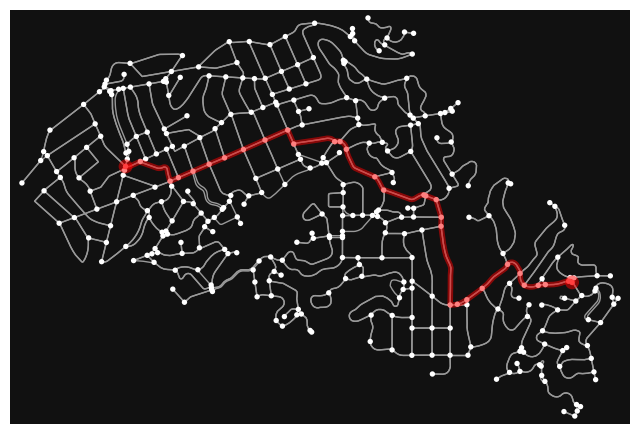

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [23]:
ox.plot_graph_route(Piedmont, chemin)

## 1.2. Algo opti en ordonnant les predecesseurs et en calculant des sommes partielles

In [6]:
## Algo opti 1


def c_Preprocessing_Graph_opti(G):
    """ Renvoie un tuple (dags,tables,table_departs,nb_chemins) avec
        - dags[i] = liste des dictionnaires de predecesseurs lors d'un Dijkstra partant de i
        - tables[i][j] = table de dimension 2 qui donne le nombre de plus courts chemins (i)-->(j)
        - table_departs_arrivees[depart][j] = table_departs_arrivees[depart][j-1] + nb de PCC (depart)-->(j)
        - table_departs[i] = table_departs[i-1] + nombre de plus court chemins (i)-->(?) """

    n = len(G)
    compteur = 0

    dags = []
    tables = np.zeros((n,n))

    # Un Dijkstra par noeud + remplissage de la table des pcc
    for source in range(n):
        pred,dist,c = c_Dijkstra_DAG(G,source)
        compteur += c

        dags.append(pred)
        compteur += c_Table_PCC_In_Place(pred,dist,source,tables[source])


    # On ordonne les predecesseurs par nombre de pcc incidents décroissant pour optimiser la génération
    for depart in range(len(dags)):
        compteur += c_Order_DAG_decreasing_chemins(tables[depart],dags[depart])


    # Tables et variables annexes pour optimisation
    table_departs_arrivees = np.copy(tables)
    compteur += n*n
    for depart in range(n):
        for k in range(n-1):
            table_departs_arrivees[depart][k+1] += table_departs_arrivees[depart][k]   #table_departs_arrivees[depart][k+1] = table_departs_arrivees[depart][k] + nb de PCC (depart)-->(k+1)
            compteur += 1

    table_departs = np.sum(tables,axis = 1)
    for k in range(n-1):
        table_departs[k+1] += table_departs[k]                                  #table_departs[k+1] = table_departs[k] + nb de PCC qui partent de k+1
        compteur += 1

    nb_chemins = int(table_departs[-1])
    prep = (dags,tables,table_departs_arrivees,table_departs,nb_chemins)

    return (prep,compteur)


def Order_DAG_decreasing_degree(G,dag):
    for k in dag.keys() :
        dag[k] = sorted(dag[k], key=lambda x : nx.degree(G,x), reverse = True)


def c_Order_DAG_decreasing_chemins(table,dag):
    compteur = 0
    for k in dag.keys() :
        dag[k] = sorted(dag[k], key=lambda x : table[x], reverse = True)
        l = len(dag[k])
        compteur += floor(l * log(l + 1))                                       # Complexité théorique
    return compteur


def c_Unranking_PCC_depart_arrivee_opti(preprocessing, depart, arrivee, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ et d'arrivée. Renvoie le plus court chemin entre départ et arrivée de rang 'rang' """
    compteur = 0
    dags,tables = preprocessing[0],preprocessing[1]

    dag_travail = dags[depart]
    table_travail = tables[depart]

    if table_travail[arrivee] == 0:
        raise Exception("depart et arrivee pas dans la même composante connexe")

    rang_reduit = rang % tables[depart][arrivee]
    compteur +=1

    chemin = [arrivee]
    noeud_courant = arrivee

    # On reconstruit le chemin de l'arrivée au départ en parcourant les prédecesseurs de proche en proche
    while (noeud_courant != depart):
        i = 0
        pred_courant = dag_travail[noeud_courant][i]

        # On cherche le bon prédecesseur
        while (rang_reduit >= table_travail[pred_courant]):
            rang_reduit = rang_reduit - table_travail[pred_courant]
            i+=1
            pred_courant = dag_travail[noeud_courant][i]
            compteur +=1

        chemin.append(pred_courant)
        noeud_courant = pred_courant
        compteur +=1

    chemin.reverse()
    compteur += len(chemin)
    return (chemin,compteur)




def c_Unranking_PCC_depart_opti(preprocessing, depart, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ. Renvoie le plus court chemin partant de départ de rang 'rang' """
    compteur = 0
    table_departs_arrivees = preprocessing[2]
    rang_reduit = rang % int(table_departs_arrivees[depart][-1])
    compteur +=1

    # On trouve le noeud d'arrivée
    arrivee,c = c_recherche_dicho(table_departs_arrivees[depart],rang_reduit)
    compteur += c

    chemin,c = c_Unranking_PCC_depart_arrivee_opti(preprocessing,depart,arrivee,rang_reduit)
    compteur += c
    return (chemin,c)



def c_Unranking_PCC_opti(preprocessing,rang):
    """Prend en argument le preprocessing de la fonction de preprocessing. Renvoie le plus court chemin de rang 'rang' """
    compteur = 0
    table_departs,nb_chemins = preprocessing[3],preprocessing[4]
    rang_reduit = rang % nb_chemins
    compteur += 1

    # On trouve le noeud de départ
    depart,c = c_recherche_dicho(table_departs,rang_reduit)
    compteur += c
    chemin,c = c_Unranking_PCC_depart_opti(preprocessing,depart,rang_reduit)
    compteur += c

    return (chemin,compteur)



def c_Uniforme_PCC_opti(preprocessing):
    """Renvoie un plus court chemin de G avec probabilité uniforme sur tous les plus courts chemins"""
    nb_chemins = preprocessing[4]
    rang = r.randint(0,nb_chemins-1)

    return c_Unranking_PCC_opti(preprocessing,rang)


In [15]:
piedmont_opti,c = c_Preprocessing_Graph_opti(Piedmont)
pcc = piedmont_opti[4]

print(f"Nombre de plus courts chemins : {pcc}. Nombre d'étapes algo : {c}")

Nombre de plus courts chemins : 620035. Nombre d'étapes algo : 3234619


In [16]:
chemin,c = c_Uniforme_PCC_opti(piedmont_opti)
chemin,c

([67,
  160,
  219,
  139,
  140,
  208,
  209,
  166,
  92,
  210,
  179,
  211,
  212,
  94,
  222,
  223,
  330,
  299,
  154,
  155,
  97,
  46,
  345,
  47,
  206,
  249,
  147],
 65)

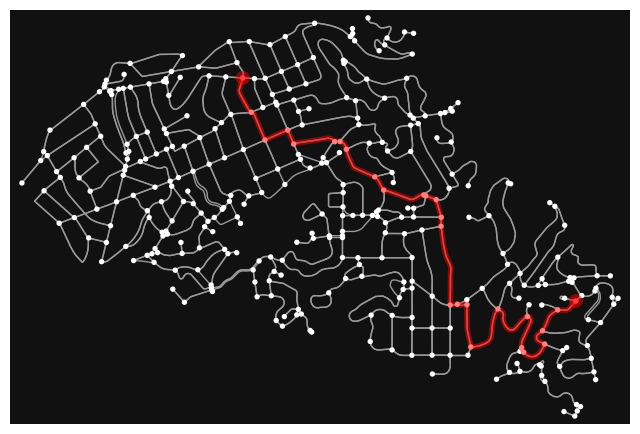

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [17]:
ox.plot_graph_route(Piedmont, chemin)

## 1.3 Comparaison performances

In [7]:
## Simulation


def calcul_donnees(fonction_prep, fonction_gen, echantillon, nbRequetes = 5):
    """Compte les opérations élémentaires lors du preprocessing et des requetes pour tout les graphes de l'échantillon"""
    donnees_prep = []
    donnees_gen = []
    nb_noeuds = []

    for G in echantillon:
        prep,compteur_prep = fonction_prep(G)

        compteur_gen = 0

        for i in range(nbRequetes):
            pcc,c = fonction_gen(prep)
            compteur_gen += c

        donnees_prep.append(compteur_prep)
        donnees_gen.append(compteur_gen)
        nb_noeuds.append(len(G))


    return (nb_noeuds,donnees_prep,donnees_gen)



def echantillon_erdos_renyi(p = lambda n : 2*log(n)/n, nb_noeuds = [floor(x) for x in np.logspace(1,2.5,50)]):
    """Génère un échantillon de graphes aléatoires d'Erdos-Renyi."""

    echantillon = []

    for n in nb_noeuds:
        echantillon.append(nx.erdos_renyi_graph(n,p(n)))

    return echantillon



def echantillon_barabasi_albert(m = 3, nb_noeuds = [floor(x) for x in np.logspace(1,2.5,50)]):
    """Génère un échantillon de graphes aléatoires de Barabasi_Albert."""

    echantillon = []

    for n in nb_noeuds:
        echantillon.append(nx.barabasi_albert_graph(n,m))

    return echantillon



def echantillon_geometrique(densite = 1, nb_noeuds = [floor(x) for x in np.logspace(1,2.5,50)]):
    """Génère un échantillon de graphes aléatoires géométriques 2D. densité = n*4/3*pi*r^3"""

    echantillon = []

    for n in nb_noeuds:
        echantillon.append(nx.random_geometric_graph(n,pow(3*densite/(n*pi*4),1/3)))

    return echantillon

In [8]:
# Dessin


def complexite_graphe(donnees,preprocessing = True, generateur = True, logScale = False):
    nb_noeuds,donnees_prep,donnees_gen = donnees

    plt.clf()
    if logScale:
        plt.xscale("log") ; plt.yscale("log")

    if preprocessing:
        plt.plot(nb_noeuds,donnees_prep, color = "green", label = "Preprocessing")

    if generateur:
        plt.plot(nb_noeuds,donnees_gen, color = "red", label = "Generateur")

    plt.legend()
    plt.show()


def complexite_comparaison_donnees(liste_donnees, preprocessing = True, generateur = True,logScale = True):


    plt.clf()
    if logScale:
        plt.xscale("log") ; plt.yscale("log")

    if preprocessing:
        for i in range(len(liste_donnees)):
            nb_noeuds,donnees_prep,donnees_gen = liste_donnees[i]
            plt.plot(nb_noeuds,donnees_prep, label = f"Preprocessing {i}")

    if generateur:
        for i in range(len(liste_donnees)):
            nb_noeuds,donnees_prep,donnees_gen = liste_donnees[i]
            plt.plot(nb_noeuds,donnees_gen, label = f"Generateur {i}")

    plt.legend()
    plt.show()



def complexite_graphe_comparaison(nb_noeuds,donnees,f,logScale = True):
    facteur_rescaling = donnees[-1]/f(nb_noeuds[-1])
    comparaison = [facteur_rescaling*f(n) for n in nb_noeuds]

    plt.clf()
    if logScale:
        plt.xscale("log") ; plt.yscale("log")

    plt.plot(nb_noeuds,donnees, color = "red", label = "Donnees")
    plt.plot(nb_noeuds,comparaison, color = "blue", label = "f(n)")
    plt.legend()
    plt.show()

In [20]:
echant_ER = echantillon_erdos_renyi(p = lambda n : 2*log(n)/n, nb_noeuds = [floor(x) for x in np.logspace(1,2.5,50)])
echant_BA = echantillon_barabasi_albert(m = 3, nb_noeuds = [floor(x) for x in np.logspace(1,2.5,50)])

In [21]:
donnees_ER_naif = calcul_donnees(c_Preprocessing_Graph_naif, c_Uniforme_PCC_naif, echant_ER)
donnees_ER_opti = calcul_donnees(c_Preprocessing_Graph_opti, c_Uniforme_PCC_opti, echant_ER)

donnees_BA_naif = calcul_donnees(c_Preprocessing_Graph_naif, c_Uniforme_PCC_naif, echant_BA)
donnees_BA_opti = calcul_donnees(c_Preprocessing_Graph_opti, c_Uniforme_PCC_opti, echant_BA)

In [22]:
donnees_ER = [donnees_ER_naif, donnees_ER_opti]
donnees_BA = [donnees_BA_naif, donnees_BA_opti]

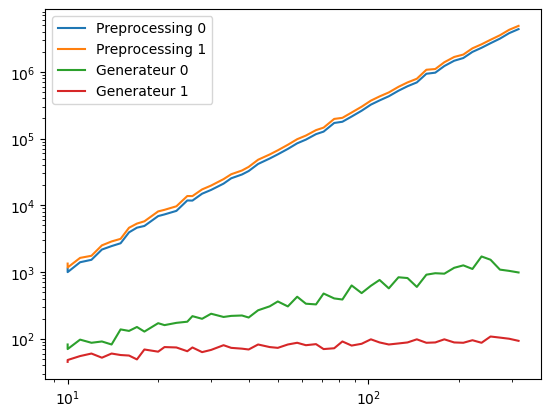

In [23]:
complexite_comparaison_donnees(donnees_ER, preprocessing = True, generateur = True,logScale = True)

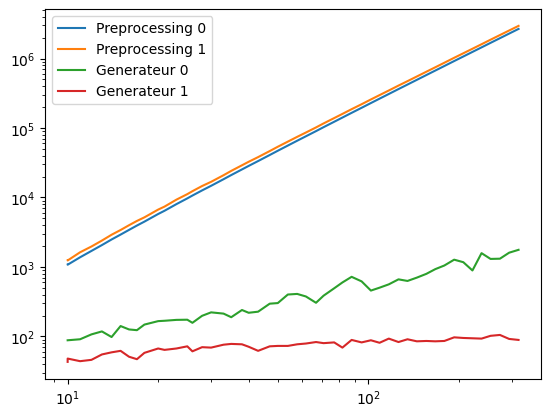

In [24]:
complexite_comparaison_donnees(donnees_BA, preprocessing = True, generateur = True,logScale = True)

## 1.4. Complexité du générateur

In [9]:
## Complexité du générateur

def complexite_generateur_donnees(prepG, fonction_gen, nbRequetes = 1000):
    tailles_chemins = []
    temps_generation = []
    for i in range(nbRequetes):
        path,compteur = fonction_gen(prepG)
        tailles_chemins.append(len(path))
        temps_generation.append(compteur)
    return (tailles_chemins,temps_generation)


def complexite_generateur_points(donnees):
    tailles_chemins,temps_generation = donnees

    plt.clf()
    plt.plot(tailles_chemins,temps_generation,"ob")
    plt.show()


def complexite_generateur_moyennes(donnees):
    tailles_chemins,temps_generation = donnees
    tailles = {}
    temps_total = {}

    for i in range(len(tailles_chemins)):
        l = tailles_chemins[i]
        tailles[l] = tailles.setdefault(l, 0) + 1
        temps_total[l] = temps_total.setdefault(l,0) + temps_generation[i]

    longueurs = []
    temps_moyen = []
    for k in tailles.keys():
        longueurs.append(k)
        temps_moyen.append(temps_total[k]/tailles[k])

    plt.clf()
    plt.plot(longueurs,temps_moyen,"ob")
    plt.show()


def complexite_generateur_comparaison(liste_donnees):
    plt.clf()

    for j in range(len(liste_donnees)):
        tailles_chemins,temps_generation = liste_donnees[j]
        tailles = {}
        temps_total = {}

        for i in range(len(tailles_chemins)):
            l = tailles_chemins[i]
            tailles[l] = tailles.setdefault(l, 0) + 1
            temps_total[l] = temps_total.setdefault(l,0) + temps_generation[i]

        longueurs = []
        temps_moyen = []
        for k in tailles.keys():
            longueurs.append(k)
            temps_moyen.append(temps_total[k]/tailles[k])


        plt.plot(longueurs,temps_moyen, "s", label = f"Generateur {j}")

    plt.legend()
    plt.show()


In [26]:
G_reg = nx.random_regular_graph(4,500)
prep_reg_naif,c = c_Preprocessing_Graph_naif(G_reg)
prep_reg_opti,c = c_Preprocessing_Graph_opti(G_reg)

pcc = prep_reg_opti[4]

print(f"Nombre de plus courts chemins : {pcc}")

Nombre de plus courts chemins : 455372


In [27]:
donnees_gen_naif = complexite_generateur_donnees(prep_reg_naif, c_Uniforme_PCC_naif, nbRequetes = 1000)
donnees_gen_opti = complexite_generateur_donnees(prep_reg_opti, c_Uniforme_PCC_opti, nbRequetes = 1000)

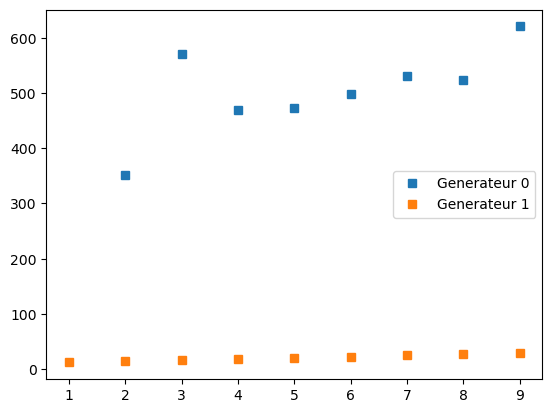

In [28]:
liste_donnees = [donnees_gen_naif,donnees_gen_opti]
complexite_generateur_comparaison(liste_donnees)

# 2. Génération de PCC à longueur fixée

In [10]:
## Utils



def recherche_dicho(table,rang):
    """Renvoie l'indice i tel que table[i-1] <= rang < table[i]"""
    if (rang < table[0]):
        return 0

    a = 0
    b = len(table)-1

    while(b-a > 1):
        #On garde l'invariant table[a] <= rang < table[b]
        m = (a + b)//2
        if table[m]<=rang:
            a = m
        else:
            b = m
    return b


def recherche_dicho_par_coordonnee(table,rang,coordonnee):
    """Renvoie l'indice i tel que table[i-1][coordonnee] <= rang < table[i][coordonnee]"""
    if (rang < table[0][coordonnee]):
        return 0

    a = 0
    b = len(table)-1

    while(b-a > 1):
        #On garde l'invariant table[a][coordonnee] <= rang < table[b][coordonnee]
        m = (a + b)//2
        if table[m][coordonnee]<=rang:
            a = m
        else:
            b = m
    return b




def inverse_dist(dist):
    """Prend le dictionnaire des distance et renvoie un dictionnaire où inv[d] = [liste des à distance d]"""
    inverse = {}
    for noeud,distance in dist.items():
        inverse.setdefault(distance, []).append(noeud)
    return inverse

In [11]:
## Fonctions

def Dijkstra_DAG(G,source):
    """Renvoie un tuple (predecesseur,distance) avec predecesseur le DAG associé au Dijkstra à partir de la source sous la forme d'un dictionnaire noeud: liste de predecesseurs et distance le dictionnaire des distances au point source"""
    pred,dist = nx.dijkstra_predecessor_and_distance(G,source)
    return pred,dist



def Table_PCC(pred,dist,source):
    """Prend en argument le couple (DAG des predecesseurs,dictionnaire des distance) dans Dijsktra qui part de source. Renvoie un tableau avec en position i le nombre de plus court chemins qui partent de la source et arrivent en i"""
    n = len(pred)
    table = np.zeros(n)

    inv_dist = inverse_dist(dist)                                               # un dictionnaire avec en inv_dist[d] = liste des sommets à distance d de la source

    table[source] = 1
    for d in range(1,len(inv_dist)) :
        for x in inv_dist[d]:
            somme = 0
            for pred_de_x in pred[x]:
                somme += table[pred_de_x]
            table[x] = somme
    return table


def Table_PCC_In_Place(pred,dist,source,table):
    """Même fonction que Table_PCC mais en remplissant la table passée en argument (supposée de la bonne taille)"""

    inv_dist = inverse_dist(dist)                                               # un dictionnaire avec en inv_dist[d] = liste des sommets à distance d de la source

    table[source] = 1
    for d in range(1,len(inv_dist)) :
        for x in inv_dist[d]:
            somme = 0
            for pred_de_x in pred[x]:
                somme += table[pred_de_x]
            table[x] = somme


def Distance_et_pcc_depuis_source(dist,table):
    """Renvoie un dictionnaire où dict[l] = liste des (sommet à distance l,nombre de pcc (source)-->(arrivee) ) """
    dico = {}
    for noeud,distance in dist.items():
        dico.setdefault(distance, []).append((noeud,table[noeud]))

    # On veut avoir des sommes partielles en 2ème coordonnée.
    for l in dico.keys():
        for i in range(1,len(dico[l])):
            arrivee,nombre_pcc_source_arrivee = dico[l][i]
            dico[l][i] = (arrivee, nombre_pcc_source_arrivee + dico[l][i-1][1])

    return dico

## 2.1. Preprocessing

In [12]:
def Preprocessing_Graph_long(G):
    """ Renvoie un tuple (dags,tables,depart_distance,dict_departs,nb_dist,nb_chemins) avec
        - dags[i] = liste des dictionnaires de predecesseurs lors d'un Dijkstra partant de i
        - tables[i][j] = table de dimension 2 qui donne le nombre de plus courts chemins (i)-->(j)
        - depart_distance[depart] = dictionnaire dont les clés sont [|0, excentricité(depart)|]
            depart_distance[depart][l] = liste des éléments (arrivée à distance l, somme partielle du nombre de PCC (depart)-->(arrivee) )
        - dict_departs[l] = liste des éléments (départ avec au moins un PCC de longueur l, nombre de PCC de longueur l de la forme (depart)-->(?) )
        - nb_pcc_par_longueur[l] = nombre de PCC de longueur <= l """

    n = len(G)

    dags = []
    tables = np.zeros((n,n))
    depart_distance = []
    dict_departs = {}
    nb_pcc_par_longueur = []
    nb_chemins = 0


    # Un Dijkstra par noeud + remplissage de la table des pcc + remplissage du dictionnaire des distances à (source)
    for source in range(n):
        pred,dist = Dijkstra_DAG(G,source)
        dags.append(pred)
        Table_PCC_In_Place(pred,dist,source,tables[source])
        distances_source = Distance_et_pcc_depuis_source(dist,tables[source])
        depart_distance.append(distances_source)


    # On ordonne les predecesseurs par nombre de pcc incidents décroissant pour optimiser la génération
    for depart in range(len(dags)):
        Order_DAG_decreasing_chemins(tables[depart],dags[depart])


    # On construit le dictionnaire dict_depart
    for depart in range(n):
        for l in range(len(depart_distance[depart])):
            derniere_arrivee,nb_pcc_distance_l = depart_distance[depart][l][-1]
            dict_departs.setdefault(l, []).append((depart,nb_pcc_distance_l))

    for l in dict_departs.keys():                                               # On veut avoir des sommes partielles en 2ème coordonnée.
        for i in range(1,len(dict_departs[l])):
            depart,pcc_depuis_depart = dict_departs[l][i]
            dict_departs[l][i] = (depart, pcc_depuis_depart + dict_departs[l][i-1][1])

    # Décompte des chemins
    for l in dict_departs.keys():
        nb_pcc_par_longueur.append(dict_departs[l][-1][1])
    for i in range(1,len(nb_pcc_par_longueur)):
        # On veut avoir des sommes partielles
        nb_pcc_par_longueur[i] += nb_pcc_par_longueur[i-1]

    nb_chemins = int(nb_pcc_par_longueur[-1])


    return (dags,tables,depart_distance,dict_departs,nb_pcc_par_longueur, nb_chemins)


def Order_DAG_decreasing_degree(G,dag):
    for k in dag.keys() :
        dag[k] = sorted(dag[k], key=lambda x : nx.degree(G,x), reverse = True)


def Order_DAG_decreasing_chemins(table,dag):
    for k in dag.keys() :
        dag[k] = sorted(dag[k], key=lambda x : table[x], reverse = True)

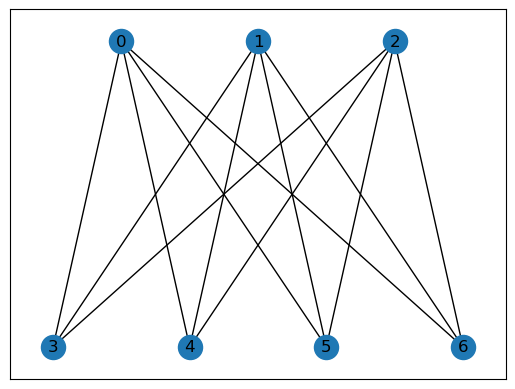

In [32]:
nx.draw_networkx(Biparti34,pos = pos_bip34)

In [33]:
bip34_long = Preprocessing_Graph_long(Biparti34)

1) Dictionnaire des predecesseurs  --> O(n(n+m))

In [34]:
bip34_long[0]

[{0: [], 3: [0], 4: [0], 5: [0], 6: [0], 1: [3, 4, 5, 6], 2: [3, 4, 5, 6]},
 {1: [], 3: [1], 4: [1], 5: [1], 6: [1], 0: [3, 4, 5, 6], 2: [3, 4, 5, 6]},
 {2: [], 3: [2], 4: [2], 5: [2], 6: [2], 0: [3, 4, 5, 6], 1: [3, 4, 5, 6]},
 {3: [], 0: [3], 1: [3], 2: [3], 4: [0, 1, 2], 5: [0, 1, 2], 6: [0, 1, 2]},
 {4: [], 0: [4], 1: [4], 2: [4], 3: [0, 1, 2], 5: [0, 1, 2], 6: [0, 1, 2]},
 {5: [], 0: [5], 1: [5], 2: [5], 3: [0, 1, 2], 4: [0, 1, 2], 6: [0, 1, 2]},
 {6: [], 0: [6], 1: [6], 2: [6], 3: [0, 1, 2], 4: [0, 1, 2], 5: [0, 1, 2]}]

2. Table du nombre de PCC entre i et j --> O(n^2)

In [35]:
bip34_long[1]

array([[1., 4., 4., 1., 1., 1., 1.],
       [4., 1., 4., 1., 1., 1., 1.],
       [4., 4., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 3., 3., 3.],
       [1., 1., 1., 3., 1., 3., 3.],
       [1., 1., 1., 3., 3., 1., 3.],
       [1., 1., 1., 3., 3., 3., 1.]])

3. Liste de dictionnaire, un par source. Dans un dictionnaire, à la clé L on a la liste des arrivées à distance L de la source. Avec le nombre de PCC entre cette arrivée et la source (somme partielle). --> O(n^2)

In [36]:
bip34_long[2][0]

{0: [(0, 1.0)],
 1: [(3, 1.0), (4, 2.0), (5, 3.0), (6, 4.0)],
 2: [(1, 4.0), (2, 8.0)]}

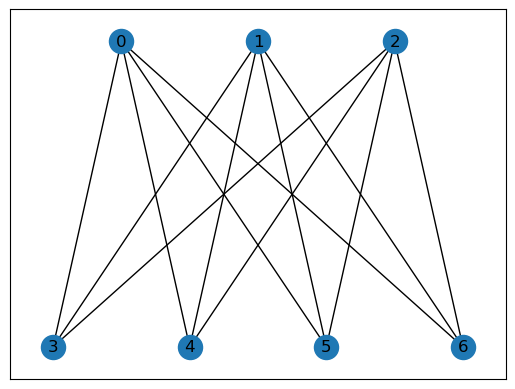

In [37]:
nx.draw_networkx(Biparti34,pos = pos_bip34)

4. Dictionnaire dont les clés sont les longueurs possibles des PCC. En clé L on a la liste des départs de PCC de longueur L avec en 2ème coordonnée le nombre de PCC partant de ce départ (somme partielle). --> O(n.diam(G)) = O(n^2)

In [39]:
bip34_long[3][2]

[(0, 8.0), (1, 16.0), (2, 24.0), (3, 33.0), (4, 42.0), (5, 51.0), (6, 60.0)]

5. Nombre de plus courts chemins de longueur L (somme partielle). --> O(diam(G)) = O(n)

In [40]:
bip34_long[4]

[7.0, 31.0, 91.0]

6. Nombre de plus courts chemins dans le Graphe --> O(1)

In [41]:
bip34_long[5]

91

In [42]:
bip34_naif,c = c_Preprocessing_Graph_naif(Biparti34)

In [43]:
bip34_naif[-1]

91.0

Le préprocessing reste de taille O(n(n+m)). C'est les dag qui peuvent être les plus gros dans la théorie.

## 2.2. Génération

In [13]:
def Unranking_PCC_depart_arrivee_long(preprocessing, depart, arrivee, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ et d'arrivée. Renvoie le plus court chemin entre départ et arrivée de rang 'rang' """

    dags,tables = preprocessing[0],preprocessing[1]

    dag_travail = dags[depart]
    table_travail = tables[depart]

    if table_travail[arrivee] == 0:
        raise Exception("depart et arrivee pas dans la même composante connexe")

    rang_reduit = rang % tables[depart][arrivee]

    chemin = [arrivee]
    noeud_courant = arrivee

    # On reconstruit le chemin de l'arrivée au départ en parcourant les prédecesseurs de proche en proche
    while (noeud_courant != depart):
        i = 0
        pred_courant = dag_travail[noeud_courant][i]

        # On cherche le bon prédecesseur
        while (rang_reduit >= table_travail[pred_courant]):
            rang_reduit = rang_reduit - table_travail[pred_courant]
            i+=1
            pred_courant = dag_travail[noeud_courant][i]

        chemin.append(pred_courant)
        noeud_courant = pred_courant

    chemin.reverse()
    return chemin




def Unranking_PCC_depart_longueur_long(preprocessing, depart, longueur, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ. Renvoie le plus court chemin de longueur 'longueur' partant de départ de rang 'rang' """

    depart_distance = preprocessing[2]

    if len(depart_distance[depart]) <= longueur :
        raise Exception("Pas de plus courts chemins de cette longueur depuis ce départ.")

    liste_arrivees = depart_distance[depart][longueur]
    nb_pcc = int(liste_arrivees[-1][1])

    rang_reduit = rang % nb_pcc

    # On trouve le noeud d'arrivée
    indice_arrivee = recherche_dicho_par_coordonnee(liste_arrivees,rang_reduit,1)
    arrivee = liste_arrivees[indice_arrivee][0]

    return Unranking_PCC_depart_arrivee_long(preprocessing,depart,arrivee,rang_reduit)



def Unranking_PCC_longueur_long(preprocessing,longueur,rang):
    """Prend en argument le preprocessing de la fonction de preprocessing. Renvoie le plus court chemin de longueur 'longueur' de rang 'rang' """

    nb_pcc_par_longueur = preprocessing[3]

    if len(nb_pcc_par_longueur) <= longueur :
        raise Exception("Pas de plus courts chemins de cette longueur.")

    liste_departs = nb_pcc_par_longueur[longueur]
    nb_pcc = int(liste_departs[-1][1])

    rang_reduit = rang % nb_pcc

    # On trouve le noeud de départ
    indice_depart = recherche_dicho_par_coordonnee(liste_departs,rang_reduit,1)
    depart = liste_departs[indice_depart][0]

    return Unranking_PCC_depart_longueur_long(preprocessing,depart,longueur,rang_reduit)


def Uniforme_PCC_longueur_long(preprocessing,longueur):
    """Renvoie un plus court chemin de G de longueur 'longueur' avec probabilité uniforme sur tous les plus courts chemins de cette longueur"""
    nb_chemins_longueur = preprocessing[4][longueur] if longueur == 0 else preprocessing[4][longueur] - preprocessing[4][longueur-1]
    rang = r.randint(0,nb_chemins_longueur-1)

    return Unranking_PCC_longueur_long(preprocessing, longueur,rang)


def Unranking_PCC_long(preprocessing,rang):
    nb_pcc_par_longueur,nb_pcc = preprocessing[4],preprocessing[5]

    rang_reduit = rang % nb_pcc
    longueur = recherche_dicho(nb_pcc_par_longueur,rang_reduit)
    return Unranking_PCC_longueur_long(preprocessing,longueur,rang_reduit)


def Uniforme_PCC_long(preprocessing):
    """Renvoie un plus court chemin de G avec probabilité uniforme sur tous les plus courts chemins"""
    nb_chemins = preprocessing[5]
    rang = r.randint(0,nb_chemins-1)

    return Unranking_PCC_long(preprocessing,rang)

In [45]:
l = 2
nb_pcc_longueur_l = bip34_long[4][l] - bip34_long[4][l-1]
print(f"Nombre de PCC de longueur {l} : {nb_pcc_longueur_l}")

Nombre de PCC de longueur 2 : 60.0


In [46]:
[Unranking_PCC_depart_longueur_long(bip34_long,0,2,r) for r in range(10)]

[[0, 3, 1],
 [0, 4, 1],
 [0, 5, 1],
 [0, 6, 1],
 [0, 3, 2],
 [0, 4, 2],
 [0, 5, 2],
 [0, 6, 2],
 [0, 3, 1],
 [0, 4, 1]]

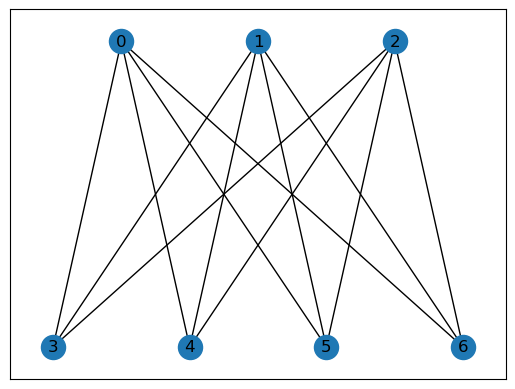

In [47]:
nx.draw_networkx(Biparti34,pos = pos_bip34)

In [48]:
piedmont_long = Preprocessing_Graph_long(Piedmont)
print(f"Taille du plus long PCC : {len(piedmont_long[4]) - 1}")

Taille du plus long PCC : 43


In [49]:
l = 33
chemin = Uniforme_PCC_longueur_long(piedmont_long,l)
chemin

[158,
 37,
 42,
 43,
 218,
 219,
 139,
 176,
 62,
 63,
 163,
 30,
 311,
 213,
 185,
 212,
 94,
 222,
 223,
 330,
 299,
 154,
 155,
 97,
 46,
 344,
 64,
 257,
 290,
 289,
 288,
 287,
 336,
 27]

In [50]:
len(chemin)-1

33

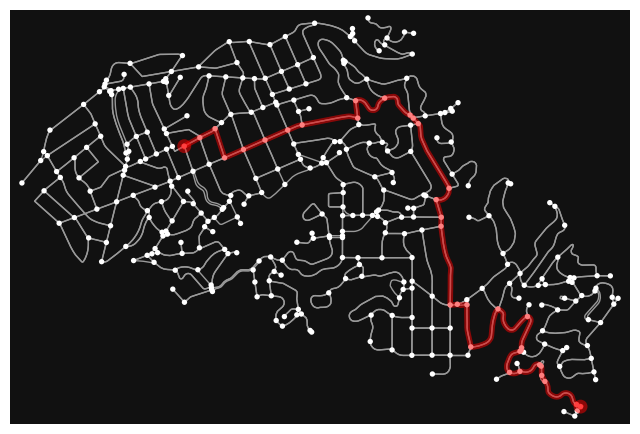

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [51]:
ox.plot_graph_route(Piedmont, chemin)

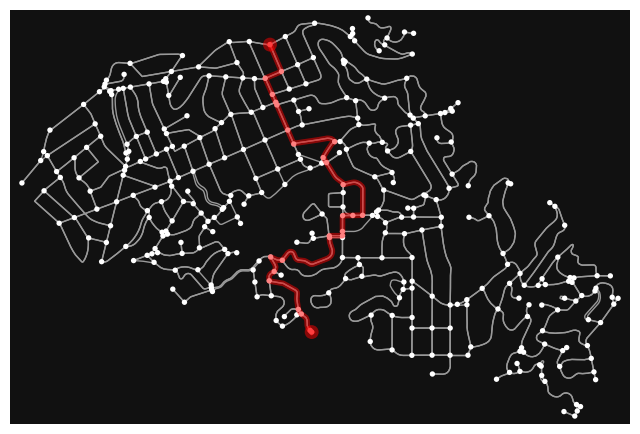

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [52]:
chemin = Uniforme_PCC_long(piedmont_long)
ox.plot_graph_route(Piedmont, chemin)

In [55]:
[piedmont_long[4][i+1]- piedmont_long[4][i] for i in range(len(piedmont_long[4])-1)]

[934.0,
 1668.0,
 2655.0,
 3813.0,
 5203.0,
 6782.0,
 8529.0,
 10486.0,
 12473.0,
 14372.0,
 16313.0,
 18721.0,
 20702.0,
 22577.0,
 24559.0,
 25550.0,
 26890.0,
 28610.0,
 30856.0,
 31992.0,
 32862.0,
 32705.0,
 30524.0,
 27771.0,
 25439.0,
 22580.0,
 20350.0,
 19675.0,
 18091.0,
 15572.0,
 12998.0,
 10789.0,
 9430.0,
 8673.0,
 7361.0,
 5044.0,
 2905.0,
 1526.0,
 899.0,
 505.0,
 232.0,
 57.0,
 10.0]

## 2.3. Optimisation du preprocessing

In [14]:
def Ajoute_somme_partielle_dag_IN_PLACE(pred,table):
    """ Après application de la fonction pred[k] = [ (pred de k, somme partielle sur les autres pred de k des pcc (source)--> (pred de k)), ... ] """
    for k in pred.keys():
        somme_partielle = 0
        for i in range(len(pred[k])):
            pred_de_k = pred[k][i]
            somme_partielle += table[pred_de_k]
            pred[k][i] = (pred_de_k, somme_partielle)


def Preprocessing_Graph_long_opti(G):
    """ Renvoie un tuple (dags,depart_distance,dict_departs,nb_dist,nb_chemins) avec
        - dags[i] = liste des dictionnaires de predecesseurs lors d'un Dijkstra partant de i avec la somme partielle en 2eme coordonnée
        - depart_distance[depart] = dictionnaire dont les clés sont [|0, excentricité(depart)|]
            depart_distance[depart][l] = liste des éléments (arrivée à distance l, somme partielle du nombre de PCC (depart)-->(arrivee) )
        - dict_departs[l] = liste des éléments (départ avec au moins un PCC de longueur l, nombre de PCC de longueur l de la forme (depart)-->(?) )
        - nb_pcc_par_longueur[l] = nombre de PCC de longueur <= l """

    n = len(G)

    dags = []
    depart_distance = []
    dict_departs = {}
    nb_pcc_par_longueur = []
    nb_chemins = 0

    #tables[i][j] = table de dimension 2 qui donne le nombre de plus courts chemins (i)-->(j)
    tables = np.zeros((n,n))



    # Un Dijkstra par noeud + remplissage de la table des pcc + remplissage du dictionnaire des distances à (source)
    for source in range(n):
        pred,dist = Dijkstra_DAG(G,source)
        dags.append(pred)
        Table_PCC_In_Place(pred,dist,source,tables[source])
        Ajoute_somme_partielle_dag_IN_PLACE(pred,tables[source])                # On ajoute à chaque prédecesseurs, la somme partielle du nombre de pcc entre (source) et lui.
        distances_source = Distance_et_pcc_depuis_source(dist,tables[source])
        depart_distance.append(distances_source)


    # On construit le dictionnaire dict_depart
    for depart in range(n):
        for l in range(len(depart_distance[depart])):
            derniere_arrivee,nb_pcc_distance_l = depart_distance[depart][l][-1]
            dict_departs.setdefault(l, []).append((depart,nb_pcc_distance_l))

    for l in dict_departs.keys():                                               # On veut avoir des sommes partielles en 2ème coordonnée.
        for i in range(1,len(dict_departs[l])):
            depart,pcc_depuis_depart = dict_departs[l][i]
            dict_departs[l][i] = (depart, pcc_depuis_depart + dict_departs[l][i-1][1])

    # Décompte des chemins
    for l in dict_departs.keys():
        nb_pcc_par_longueur.append(dict_departs[l][-1][1])
    for i in range(1,len(nb_pcc_par_longueur)):
        # On veut avoir des sommes partielles
        nb_pcc_par_longueur[i] += nb_pcc_par_longueur[i-1]

    nb_chemins = int(nb_pcc_par_longueur[-1])


    return (dags,depart_distance,dict_departs,nb_pcc_par_longueur, nb_chemins)

In [15]:
Biparti34bis = Biparti34.copy()
Biparti34bis.add_node(7)
Biparti34bis.add_edge(2,7)

pos_bip34bis = {0 : [-1,1], 1 : [0,1], 2 : [1, 1], 3 : [-1.5, -1], 4 : [-0.5, -1], 5 : [0.5, -1], 6 : [1.5, -1], 7 : [2,1]}

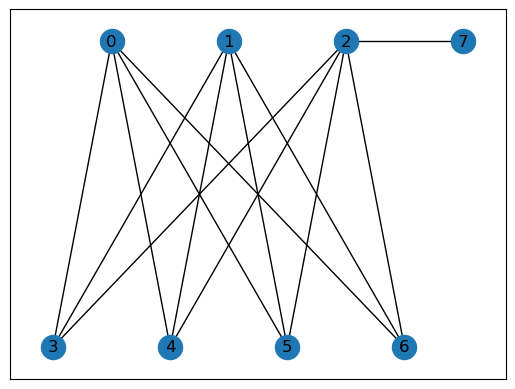

In [16]:
nx.draw_networkx(Biparti34bis,pos = pos_bip34bis)

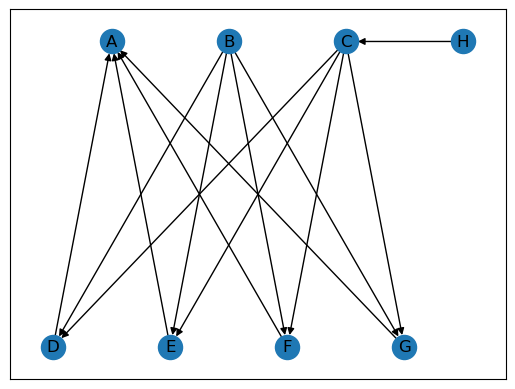

In [17]:
Biparti34bis_DAG = nx.DiGraph(Biparti34bis)
Biparti34bis_DAG.remove_edges_from([(0,3), (0,4), (0,5), (0,6), (3,1), (3,2), (4,1), (4,2), (5,1), (5,2), (6,1), (6,2), (2,7)])

mapping = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6 : "G", 7 : "H"}
H = nx.relabel_nodes(Biparti34bis_DAG, mapping)

pos_bip34bis = {"A" : [-1,1], "B" : [0,1], "C" : [1, 1], "D" : [-1.5, -1], "E" : [-0.5, -1], "F" : [0.5, -1], "G" : [1.5, -1], "H" : [2,1]}
nx.draw_networkx(H,pos = pos_bip34bis)

In [18]:
bip34bis_long_opti = Preprocessing_Graph_long_opti(Biparti34bis)

1. Dans chaque dag, on ajoute un champ après le prédécesseur qui indique combien on a de PCC entre la source et lui. Somme partielle sur tous les predecesseurs. --> O(n(n+m))

In [20]:
bip34bis_long_opti[0][0]

{0: [],
 3: [(0, 1.0)],
 4: [(0, 1.0)],
 5: [(0, 1.0)],
 6: [(0, 1.0)],
 1: [(3, 1.0), (4, 2.0), (5, 3.0), (6, 4.0)],
 2: [(3, 1.0), (4, 2.0), (5, 3.0), (6, 4.0)],
 7: [(2, 4.0)]}

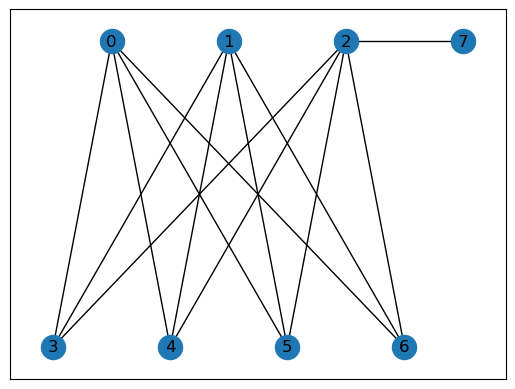

In [61]:
nx.draw_networkx(Biparti34bis,pos = pos_bip34bis)

In [62]:
def Unranking_PCC_depart_arrivee_long_opti(preprocessing, depart, arrivee, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ et d'arrivée. Renvoie le plus court chemin entre départ et arrivée de rang 'rang' """

    dags = preprocessing[0]

    dag_travail = dags[depart]

    if not (arrivee in dag_travail):
        raise Exception("depart et arrivee pas dans la même composante connexe")

    if len(dag_travail[arrivee]) > 0:
        nb_pcc_depart_arrivee = dag_travail[arrivee][-1][1]
        rang_reduit = rang % nb_pcc_depart_arrivee

    chemin = [arrivee]
    noeud_courant = arrivee

    # On reconstruit le chemin de l'arrivée au départ en parcourant les prédecesseurs de proche en proche
    while (noeud_courant != depart):
        liste_pred = dag_travail[noeud_courant]
        indice_nv_noeud = recherche_dicho_par_coordonnee(liste_pred,rang_reduit,1)
        if indice_nv_noeud > 0:
            rang_reduit = rang_reduit - liste_pred[indice_nv_noeud - 1][1]

        noeud_courant = liste_pred[indice_nv_noeud][0]

        chemin.append(noeud_courant)

    chemin.reverse()
    return chemin




def Unranking_PCC_depart_longueur_long_opti(preprocessing, depart, longueur, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ. Renvoie le plus court chemin de longueur 'longueur' partant de départ de rang 'rang' """

    depart_distance = preprocessing[1]

    if len(depart_distance[depart]) <= longueur :
        raise Exception("Pas de plus courts chemins de cette longueur depuis ce départ.")

    liste_arrivees = depart_distance[depart][longueur]
    nb_pcc = int(liste_arrivees[-1][1])

    rang_reduit = rang % nb_pcc

    # On trouve le noeud d'arrivée
    indice_arrivee = recherche_dicho_par_coordonnee(liste_arrivees,rang_reduit,1)
    arrivee = liste_arrivees[indice_arrivee][0]

    return Unranking_PCC_depart_arrivee_long_opti(preprocessing,depart,arrivee,rang_reduit)



def Unranking_PCC_longueur_long_opti(preprocessing,longueur,rang):
    """Prend en argument le preprocessing de la fonction de preprocessing. Renvoie le plus court chemin de longueur 'longueur' de rang 'rang' """

    nb_pcc_par_longueur = preprocessing[2]

    if len(nb_pcc_par_longueur) <= longueur :
        raise Exception("Pas de plus courts chemins de cette longueur.")

    liste_departs = nb_pcc_par_longueur[longueur]
    nb_pcc = int(liste_departs[-1][1])

    rang_reduit = rang % nb_pcc

    # On trouve le noeud de départ
    indice_depart = recherche_dicho_par_coordonnee(liste_departs,rang_reduit,1)
    depart = liste_departs[indice_depart][0]

    return Unranking_PCC_depart_longueur_long_opti(preprocessing,depart,longueur,rang_reduit)


def Uniforme_PCC_longueur_long_opti(preprocessing,longueur):
    """Renvoie un plus court chemin de G de longueur 'longueur' avec probabilité uniforme sur tous les plus courts chemins de cette longueur"""
    nb_chemins_longueur = preprocessing[3][longueur] if longueur == 0 else preprocessing[3][longueur] - preprocessing[3][longueur-1]
    rang = r.randint(0,nb_chemins_longueur-1)

    return Unranking_PCC_longueur_long_opti(preprocessing, longueur,rang)


def Unranking_PCC_long_opti(preprocessing,rang):
    nb_pcc_par_longueur,nb_pcc = preprocessing[3],preprocessing[4]

    rang_reduit = rang % nb_pcc
    longueur = recherche_dicho(nb_pcc_par_longueur,rang_reduit)
    return Unranking_PCC_longueur_long_opti(preprocessing,longueur,rang_reduit)


def Uniforme_PCC_long_opti(preprocessing):
    """Renvoie un plus court chemin de G avec probabilité uniforme sur tous les plus courts chemins"""
    nb_chemins = preprocessing[4]
    rang = r.randint(0,nb_chemins-1)

    return Unranking_PCC_long_opti(preprocessing,rang)

In [77]:
piedmont_long_opti = Preprocessing_Graph_long_opti(Piedmont)
print(f"Taille du plus long PCC : {len(piedmont_long_opti[3]) - 1}")

Taille du plus long PCC : 43


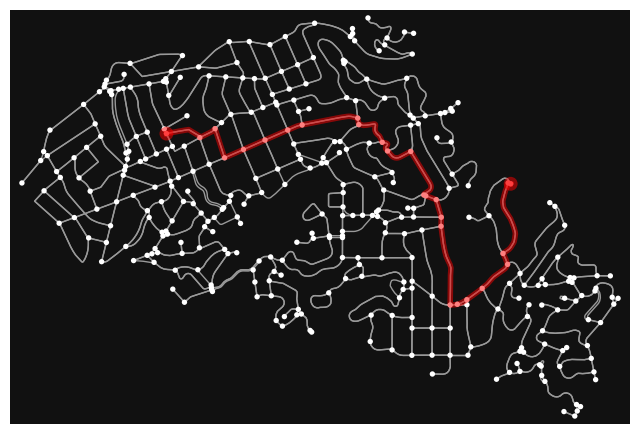

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [64]:
l = 25
chemin = Uniforme_PCC_longueur_long_opti(piedmont_long_opti,l)
ox.plot_graph_route(Piedmont, chemin)

# 3. Comparaison des algo

In [65]:
## Algo long


def c_Distance_et_pcc_depuis_source(dist,table):
    """Renvoie un dictionnaire où dict[l] = liste des (sommet à distance l,nombre de pcc (source)-->(arrivee) ) """
    compteur = 0
    dico = {}

    for noeud,distance in dist.items():
        dico.setdefault(distance, []).append((noeud,table[noeud]))
        compteur += 1

    # On veut avoir des sommes partielles en 2ème coordonnée.
    for l in dico.keys():
        for i in range(1,len(dico[l])):
            arrivee,nombre_pcc_source_arrivee = dico[l][i]
            dico[l][i] = (arrivee, nombre_pcc_source_arrivee + dico[l][i-1][1])
            compteur += 1

    return (dico,compteur)



def c_Preprocessing_Graph_long(G):
    """ Renvoie un tuple (dags,tables,depart_distance,dict_departs,nb_dist,nb_chemins) avec
        - dags[i] = liste des dictionnaires de predecesseurs lors d'un Dijkstra partant de i
        - tables[i][j] = table de dimension 2 qui donne le nombre de plus courts chemins (i)-->(j)
        - depart_distance[depart] = dictionnaire dont les clés sont [|0, excentricité(depart)|]
            depart_distance[depart][l] = liste des éléments (arrivée à distance l, somme partielle du nombre de PCC (depart)-->(arrivee) )
        - dict_departs[l] = liste des éléments (départ avec au moins un PCC de longueur l, nombre de PCC de longueur l de la forme (depart)-->(?) )
        - nb_pcc_par_longueur[l] = nombre de PCC de longueur <= l """

    compteur = 0
    n = len(G)

    dags = []
    tables = np.zeros((n,n))
    depart_distance = []
    dict_departs = {}
    nb_pcc_par_longueur = []
    nb_chemins = 0


    # Un Dijkstra par noeud + remplissage de la table des pcc + remplissage du dictionnaire des distances à (source)
    for source in range(n):
        pred,dist,c = c_Dijkstra_DAG(G,source)
        compteur += c

        dags.append(pred)
        c = c_Table_PCC_In_Place(pred,dist,source,tables[source])
        compteur += c

        distances_source,c = c_Distance_et_pcc_depuis_source(dist,tables[source])
        compteur += c

        depart_distance.append(distances_source)
        compteur += 1


    # On ordonne les predecesseurs par nombre de pcc incidents décroissant pour optimiser la génération
    for depart in range(len(dags)):
        c = c_Order_DAG_decreasing_chemins(tables[depart],dags[depart])
        compteur += c


    # On construit le dictionnaire dict_depart
    for depart in range(n):
        for l in range(len(depart_distance[depart])):
            derniere_arrivee,nb_pcc_distance_l = depart_distance[depart][l][-1]
            dict_departs.setdefault(l, []).append((depart,nb_pcc_distance_l))
            compteur += 1

    for l in dict_departs.keys():                                               # On veut avoir des sommes partielles en 2ème coordonnée.
        for i in range(1,len(dict_departs[l])):
            depart,pcc_depuis_depart = dict_departs[l][i]
            dict_departs[l][i] = (depart, pcc_depuis_depart + dict_departs[l][i-1][1])
            compteur += 1

    # Décompte des chemins
    for l in dict_departs.keys():
        nb_pcc_par_longueur.append(dict_departs[l][-1][1])
        compteur += 1
    for i in range(1,len(nb_pcc_par_longueur)):
        # On veut avoir des sommes partielles
        nb_pcc_par_longueur[i] += nb_pcc_par_longueur[i-1]
        compteur += 1

    nb_chemins = int(nb_pcc_par_longueur[-1])
    compteur += 1

    pred = (dags,tables,depart_distance,dict_departs,nb_pcc_par_longueur, nb_chemins)
    return (pred,compteur)


def c_Unranking_PCC_depart_arrivee_long(preprocessing, depart, arrivee, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ et d'arrivée. Renvoie le plus court chemin entre départ et arrivée de rang 'rang' """

    compteur = 0
    dags,tables = preprocessing[0],preprocessing[1]

    dag_travail = dags[depart]
    table_travail = tables[depart]

    if table_travail[arrivee] == 0:
        raise Exception("depart et arrivee pas dans la même composante connexe")

    rang_reduit = rang % tables[depart][arrivee]
    compteur += 1

    chemin = [arrivee]
    noeud_courant = arrivee
    compteur += 1

    # On reconstruit le chemin de l'arrivée au départ en parcourant les prédecesseurs de proche en proche
    while (noeud_courant != depart):
        i = 0
        pred_courant = dag_travail[noeud_courant][i]

        # On cherche le bon prédecesseur
        while (rang_reduit >= table_travail[pred_courant]):
            rang_reduit = rang_reduit - table_travail[pred_courant]
            i+=1
            pred_courant = dag_travail[noeud_courant][i]
            compteur += 1

        chemin.append(pred_courant)
        noeud_courant = pred_courant
        compteur += 1

    chemin.reverse()
    compteur += len(chemin)

    return (chemin,compteur)




def c_Unranking_PCC_depart_longueur_long(preprocessing, depart, longueur, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ. Renvoie le plus court chemin de longueur 'longueur' partant de départ de rang 'rang' """

    compteur = 0
    depart_distance = preprocessing[2]

    if len(depart_distance[depart]) <= longueur :
        raise Exception("Pas de plus courts chemins de cette longueur depuis ce départ.")

    liste_arrivees = depart_distance[depart][longueur]
    nb_pcc = int(liste_arrivees[-1][1])

    rang_reduit = rang % nb_pcc
    compteur += 1

    # On trouve le noeud d'arrivée
    indice_arrivee,c = c_recherche_dicho_par_coordonnee(liste_arrivees,rang_reduit,1)
    compteur += c

    arrivee = liste_arrivees[indice_arrivee][0]

    chemin,c = c_Unranking_PCC_depart_arrivee_long(preprocessing,depart,arrivee,rang_reduit)
    compteur += c

    return (chemin,compteur)



def c_Unranking_PCC_longueur_long(preprocessing,longueur,rang):
    """Prend en argument le preprocessing de la fonction de preprocessing. Renvoie le plus court chemin de longueur 'longueur' de rang 'rang' """

    compteur = 0
    nb_pcc_par_longueur = preprocessing[3]

    if len(nb_pcc_par_longueur) <= longueur :
        raise Exception("Pas de plus courts chemins de cette longueur.")

    liste_departs = nb_pcc_par_longueur[longueur]
    nb_pcc = int(liste_departs[-1][1])

    rang_reduit = rang % nb_pcc
    compteur += 1

    # On trouve le noeud de départ
    indice_depart,c = c_recherche_dicho_par_coordonnee(liste_departs,rang_reduit,1)
    compteur += c
    depart = liste_departs[indice_depart][0]

    chemin,c = c_Unranking_PCC_depart_longueur_long(preprocessing,depart,longueur,rang_reduit)

    compteur += c

    return (chemin,compteur)


def c_Unranking_PCC_long(preprocessing,rang):
    compteur = 0
    nb_pcc_par_longueur,nb_pcc = preprocessing[4],preprocessing[5]

    rang_reduit = rang % nb_pcc
    compteur += 1

    longueur,c = c_recherche_dicho(nb_pcc_par_longueur,rang_reduit)
    compteur += c

    chemin,c = c_Unranking_PCC_longueur_long(preprocessing,longueur,rang_reduit)
    compteur += c

    return (chemin,compteur)


def c_Uniforme_PCC_long(preprocessing):
    """Renvoie un plus court chemin de G avec probabilité uniforme sur tous les plus courts chemins"""
    compteur = 0
    nb_chemins = preprocessing[5]
    rang = r.randint(0,nb_chemins-1)
    compteur += 1

    chemin,c = c_Unranking_PCC_long(preprocessing,rang)
    compteur += c

    return (chemin,compteur)



In [66]:
## Algo Longueur opti 2



def c_Ajoute_somme_partielle_dag_IN_PLACE(pred,table):
    """ Après application de la fonction pred[k] = [ (pred de k, somme partielle sur les autres pred de k des pcc (source)--> (pred de k)), ... ] """
    compteur = 0
    for k in pred.keys():
        somme_partielle = 0
        for i in range(len(pred[k])):
            pred_de_k = pred[k][i]
            somme_partielle += table[pred_de_k]
            pred[k][i] = (pred_de_k, somme_partielle)
            compteur += 1

    return compteur


def c_Preprocessing_Graph_long_opti(G):
    """ Renvoie un tuple (dags,depart_distance,dict_departs,nb_dist,nb_chemins) avec
        - dags[i] = liste des dictionnaires de predecesseurs lors d'un Dijkstra partant de i avec la somme partielle en 2eme coordonnée
        - depart_distance[depart] = dictionnaire dont les clés sont [|0, excentricité(depart)|]
            depart_distance[depart][l] = liste des éléments (arrivée à distance l, somme partielle du nombre de PCC (depart)-->(arrivee) )
        - dict_departs[l] = liste des éléments (départ avec au moins un PCC de longueur l, nombre de PCC de longueur l de la forme (depart)-->(?) )
        - nb_pcc_par_longueur[l] = nombre de PCC de longueur <= l """

    compteur = 0
    n = len(G)

    dags = []
    depart_distance = []
    dict_departs = {}
    nb_pcc_par_longueur = []
    nb_chemins = 0

    #tables[i][j] = table de dimension 2 qui donne le nombre de plus courts chemins (i)-->(j)
    tables = np.zeros((n,n))



    # Un Dijkstra par noeud + remplissage de la table des pcc + remplissage du dictionnaire des distances à (source)
    for source in range(n):
        pred,dist,c = c_Dijkstra_DAG(G,source)
        compteur += c

        dags.append(pred)
        compteur += 1

        c = c_Table_PCC_In_Place(pred,dist,source,tables[source])
        compteur += c

        c = c_Ajoute_somme_partielle_dag_IN_PLACE(pred,tables[source])                # On ajoute à chaque prédecesseurs, la somme partielle du nombre de pcc entre (source) et lui.
        compteur += c

        distances_source,c = c_Distance_et_pcc_depuis_source(dist,tables[source])
        compteur += c

        depart_distance.append(distances_source)
        compteur += 1


    # On construit le dictionnaire dict_depart
    for depart in range(n):
        for l in range(len(depart_distance[depart])):
            derniere_arrivee,nb_pcc_distance_l = depart_distance[depart][l][-1]
            dict_departs.setdefault(l, []).append((depart,nb_pcc_distance_l))
            compteur += 1

    for l in dict_departs.keys():                                               # On veut avoir des sommes partielles en 2ème coordonnée.
        for i in range(1,len(dict_departs[l])):
            depart,pcc_depuis_depart = dict_departs[l][i]
            dict_departs[l][i] = (depart, pcc_depuis_depart + dict_departs[l][i-1][1])
            compteur += 1

    # Décompte des chemins
    for l in dict_departs.keys():
        nb_pcc_par_longueur.append(dict_departs[l][-1][1])
        compteur += 1
    for i in range(1,len(nb_pcc_par_longueur)):
        # On veut avoir des sommes partielles
        nb_pcc_par_longueur[i] += nb_pcc_par_longueur[i-1]
        compteur += 1

    nb_chemins = int(nb_pcc_par_longueur[-1])
    compteur += 1

    prep = (dags,depart_distance,dict_departs,nb_pcc_par_longueur, nb_chemins)

    return (prep,compteur)


def c_Unranking_PCC_depart_arrivee_long_opti(preprocessing, depart, arrivee, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ et d'arrivée. Renvoie le plus court chemin entre départ et arrivée de rang 'rang' """

    compteur = 0
    dags = preprocessing[0]

    dag_travail = dags[depart]

    if not (arrivee in dag_travail):
        raise Exception("depart et arrivee pas dans la même composante connexe")

    if len(dag_travail[arrivee]) > 0:
        nb_pcc_depart_arrivee = dag_travail[arrivee][-1][1]
        rang_reduit = rang % nb_pcc_depart_arrivee
        compteur += 1

    chemin = [arrivee]
    noeud_courant = arrivee
    compteur += 1

    # On reconstruit le chemin de l'arrivée au départ en parcourant les prédecesseurs de proche en proche
    while (noeud_courant != depart):
        liste_pred = dag_travail[noeud_courant]
        indice_nv_noeud,c = c_recherche_dicho_par_coordonnee(liste_pred,rang_reduit,1)
        compteur += c

        if indice_nv_noeud > 0:
            rang_reduit = rang_reduit - liste_pred[indice_nv_noeud - 1][1]
            compteur += 1

        noeud_courant = liste_pred[indice_nv_noeud][0]

        chemin.append(noeud_courant)
        compteur += 1

    chemin.reverse()
    compteur += len(chemin)

    return (chemin,compteur)




def c_Unranking_PCC_depart_longueur_long_opti(preprocessing, depart, longueur, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ. Renvoie le plus court chemin de longueur 'longueur' partant de départ de rang 'rang' """

    compteur = 0
    depart_distance = preprocessing[1]

    if len(depart_distance[depart]) <= longueur :
        raise Exception("Pas de plus courts chemins de cette longueur depuis ce départ.")

    liste_arrivees = depart_distance[depart][longueur]
    nb_pcc = int(liste_arrivees[-1][1])

    rang_reduit = rang % nb_pcc
    compteur += 1

    # On trouve le noeud d'arrivée
    indice_arrivee,c = c_recherche_dicho_par_coordonnee(liste_arrivees,rang_reduit,1)
    compteur += c

    arrivee = liste_arrivees[indice_arrivee][0]

    chemin,c = c_Unranking_PCC_depart_arrivee_long_opti(preprocessing,depart,arrivee,rang_reduit)
    compteur += c

    return (chemin,compteur)



def c_Unranking_PCC_longueur_long_opti(preprocessing,longueur,rang):
    """Prend en argument le preprocessing de la fonction de preprocessing. Renvoie le plus court chemin de longueur 'longueur' de rang 'rang' """

    compteur = 0
    nb_pcc_par_longueur = preprocessing[2]

    if len(nb_pcc_par_longueur) <= longueur :
        raise Exception("Pas de plus courts chemins de cette longueur.")

    liste_departs = nb_pcc_par_longueur[longueur]
    nb_pcc = int(liste_departs[-1][1])

    rang_reduit = rang % nb_pcc
    compteur += 1

    # On trouve le noeud de départ
    indice_depart,c = c_recherche_dicho_par_coordonnee(liste_departs,rang_reduit,1)
    compteur += c

    depart = liste_departs[indice_depart][0]

    chemin,c = c_Unranking_PCC_depart_longueur_long_opti(preprocessing,depart,longueur,rang_reduit)
    compteur += c

    return (chemin,c)


def c_Unranking_PCC_long_opti(preprocessing,rang):
    compteur = 0
    nb_pcc_par_longueur,nb_pcc = preprocessing[3],preprocessing[4]

    rang_reduit = rang % nb_pcc
    compteur += 1

    longueur,c = c_recherche_dicho(nb_pcc_par_longueur,rang_reduit)
    compteur += c

    chemin,c = c_Unranking_PCC_longueur_long_opti(preprocessing,longueur,rang_reduit)
    compteur += c

    return (chemin,compteur)


def c_Uniforme_PCC_long_opti(preprocessing):
    """Renvoie un plus court chemin de G avec probabilité uniforme sur tous les plus courts chemins"""
    compteur = 0
    nb_chemins = preprocessing[4]
    rang = r.randint(0,nb_chemins-1)
    compteur += 1

    chemin,c = c_Unranking_PCC_long_opti(preprocessing,rang)
    compteur += c

    return (chemin,compteur)


## 3.1. Comparaison performances

In [67]:
echant_ER = echantillon_erdos_renyi(p = lambda n : 2*log(n)/n, nb_noeuds = [floor(x) for x in np.logspace(1,2.5,50)])
echant_BA = echantillon_barabasi_albert(m = 3, nb_noeuds = [floor(x) for x in np.logspace(1,2.5,50)])

In [68]:
donnees_ER_naif = calcul_donnees(c_Preprocessing_Graph_naif, c_Uniforme_PCC_naif, echant_ER)
donnees_ER_opti = calcul_donnees(c_Preprocessing_Graph_opti, c_Uniforme_PCC_opti, echant_ER)
donnees_ER_long = calcul_donnees(c_Preprocessing_Graph_long, c_Uniforme_PCC_long, echant_ER)
donnees_ER_long_opti = calcul_donnees(c_Preprocessing_Graph_long_opti, c_Uniforme_PCC_long_opti, echant_ER)

donnees_BA_naif = calcul_donnees(c_Preprocessing_Graph_naif, c_Uniforme_PCC_naif, echant_BA)
donnees_BA_opti = calcul_donnees(c_Preprocessing_Graph_opti, c_Uniforme_PCC_opti, echant_BA)
donnees_BA_long = calcul_donnees(c_Preprocessing_Graph_long, c_Uniforme_PCC_long, echant_BA)
donnees_BA_long_opti = calcul_donnees(c_Preprocessing_Graph_long_opti, c_Uniforme_PCC_long_opti, echant_BA)

In [69]:
donnees_ER = [donnees_ER_naif, donnees_ER_opti, donnees_ER_long, donnees_ER_long_opti]
donnees_BA = [donnees_BA_naif, donnees_BA_opti, donnees_BA_long, donnees_BA_long_opti]

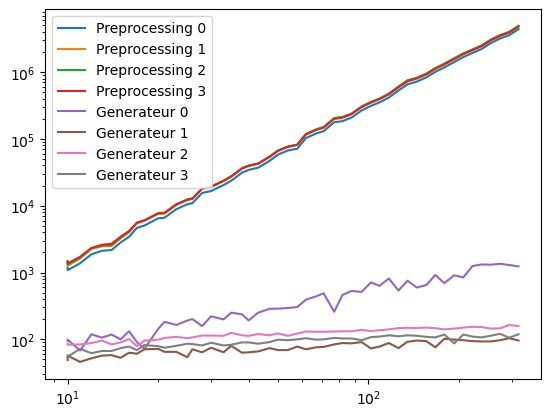

In [70]:
complexite_comparaison_donnees(donnees_ER, preprocessing = True, generateur = True,logScale = True)

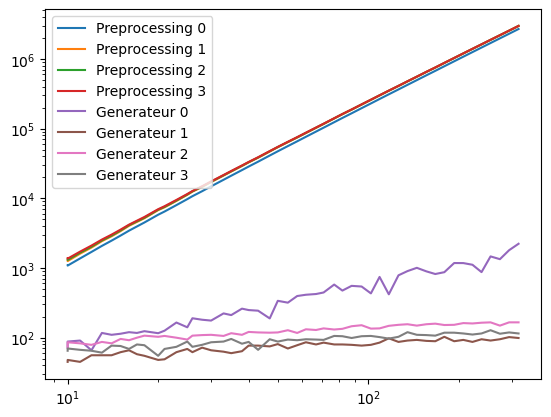

In [71]:
complexite_comparaison_donnees(donnees_BA, preprocessing = True, generateur = True,logScale = True)

## 3.2. Comparaison générateur

In [72]:
G_reg = nx.random_regular_graph(4,500)
prep_reg_naif,c = c_Preprocessing_Graph_naif(G_reg)
prep_reg_opti,c = c_Preprocessing_Graph_opti(G_reg)
prep_reg_long,c = c_Preprocessing_Graph_long(G_reg)
prep_reg_long_opti,c = c_Preprocessing_Graph_long_opti(G_reg)

pcc = prep_reg_opti[4]

print(f"Nombre de plus courts chemins : {pcc}")

Nombre de plus courts chemins : 455886


In [73]:
donnees_gen_naif = complexite_generateur_donnees(prep_reg_naif, c_Uniforme_PCC_naif, nbRequetes = 1000)
donnees_gen_opti = complexite_generateur_donnees(prep_reg_opti, c_Uniforme_PCC_opti, nbRequetes = 1000)
donnees_gen_long = complexite_generateur_donnees(prep_reg_long, c_Uniforme_PCC_long, nbRequetes = 1000)
donnees_gen_long_opti = complexite_generateur_donnees(prep_reg_long_opti, c_Uniforme_PCC_long_opti, nbRequetes = 1000)

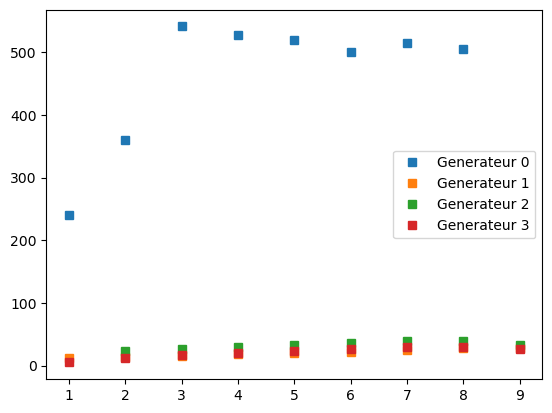

In [74]:
liste_donnees = [donnees_gen_naif,donnees_gen_opti,donnees_gen_long,donnees_gen_long_opti]
complexite_generateur_comparaison(liste_donnees)

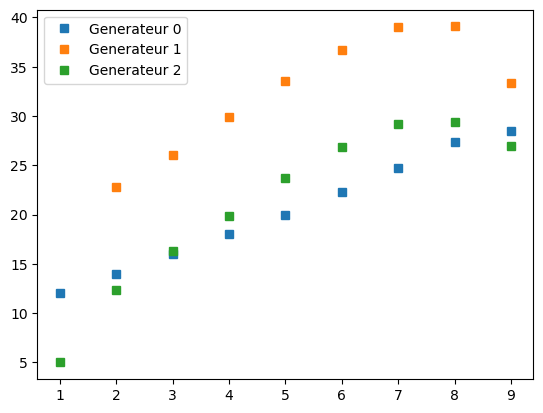

In [75]:
liste_donnees = [donnees_gen_opti,donnees_gen_long,donnees_gen_long_opti]
complexite_generateur_comparaison(liste_donnees)

Rappel :
- Générateur_opti = ordonner par nb de PCC décroissant
- Générateur_long_opti = on fait une dichotomie à toutes les étapes de reconstitution du chemin

In [76]:
piedmont_long[4]

[352.0,
 1286.0,
 2954.0,
 5609.0,
 9422.0,
 14625.0,
 21407.0,
 29936.0,
 40422.0,
 52895.0,
 67267.0,
 83580.0,
 102301.0,
 123003.0,
 145580.0,
 170139.0,
 195689.0,
 222579.0,
 251189.0,
 282045.0,
 314037.0,
 346899.0,
 379604.0,
 410128.0,
 437899.0,
 463338.0,
 485918.0,
 506268.0,
 525943.0,
 544034.0,
 559606.0,
 572604.0,
 583393.0,
 592823.0,
 601496.0,
 608857.0,
 613901.0,
 616806.0,
 618332.0,
 619231.0,
 619736.0,
 619968.0,
 620025.0,
 620035.0]